## Project Planning
* **Goal:** predict if a passenger survived (1 / 0) 
* **Metrics:** accuracy
* **TODO**:
    - Eploratory Data Analysis
        * Understand what kind of data we are using (categorical, numerical)
        * `df.info()` `df.describe()` `df.shape()`
        * Missing values, `df.corr()`, work with concatenated dataset
    - Feature Engineering
    - Model Building

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
def concat_df(train_data, test_data):
    # Concatenates training and test sets
    # reset_index(drop=True) deletes original index, and replaces with 0,1,2...N
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)
    
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df_all = concat_df(df_train, df_test) # Good when dealing with missing values to overcome overfitting

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print(f"Training Set = {df_train.shape}")
print(f"Test Set = {df_test.shape}\n")
print(df_train.columns)
print(df_test.columns)

Training Set = (891, 12)
Test Set = (418, 11)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## Eploratory Data Analysis

### 1.1 Overview
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [3]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
242,1134,1,"Spedden, Mr. Frederic Oakley",male,45.0,1,1,16966,134.5000,E34,C
182,1074,1,"Marvin, Mrs. Daniel Warner (Mary Graham Carmic...",female,18.0,1,0,113773,53.1000,D30,S
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S


### 1.2 Missing Values
* Training set have missing values in Age, Cabin and Embarked columns.
* Test set have missing values in Age, Cabin and Fare columns.
* It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples.

In [5]:
def display_missing(df):
    for col in df.columns.tolist():
        print(f'{col} column missing values: {df[col].isnull().sum()}')
    print('\n')

for df in dfs:
    print(f'{df.name}')
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [6]:
df_all.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000,0.179,-0.151,0.029,-0.408,-0.244,-0.077
Fare,0.179,1.000,0.222,0.031,-0.559,0.160,0.257
Parch,-0.151,0.222,1.000,0.009,0.018,0.374,0.082
PassengerId,0.029,0.031,0.009,1.000,-0.038,-0.055,-0.005
Pclass,-0.408,-0.559,0.018,-0.038,1.000,0.061,-0.338
SibSp,-0.244,0.160,0.374,-0.055,0.061,1.000,-0.035
Survived,-0.077,0.257,0.082,-0.005,-0.338,-0.035,1.000


#### 1.2.1 Age
Replace with median age, but not median age of the whole dataset.

But with the medians of Sex and Pclass groups

In [7]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age'] # Check with Pclass too

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [8]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']
print(age_by_pclass_sex, '\n')

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64 

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


#### 1.2.2 Embarked
2 missing values, let's see them. Both female, 1st class, same ticket number. That means they knew each other. 

Let's check the mode for female upper class embarked. 

Sometimes googling will also help.

In [9]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [10]:
df_all.groupby(['Sex', 'Pclass']).agg(lambda x:x.value_counts().index[0])['Embarked'] # Only female upper class embarked = S

Sex     Pclass
female  1         C
        2         S
        3         S
male    1         S
        2         S
        3         S
Name: Embarked, dtype: object

In [11]:
df_all['Embarked'].mode() # All people = S

0    S
dtype: object

In [12]:
df_all.groupby(['Embarked']).agg(lambda x:x.value_counts().index[0])['Pclass'] # Only upper class both male / female = C

Embarked
C    1
Q    3
S    3
Name: Pclass, dtype: int64

In [13]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### 1.2.3 Fare

There is only one passenger with missing Fare value. We can assume that Fare is related to family size (Parch and SibSp) and Pclass features. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [14]:
df_all[df_all['Fare'].isnull()] # Looking at the null value

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [15]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[3][0][0]
print(med_fare)

# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

7.8542


#### 1.2.4 Cabin

<img src="Titanic_side_plan.png">

* On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset
* A, B and C decks were only for 1st class passengers
* D and E decks were for all classes
* F and G decks were for both 2nd and 3rd class passengers
* From going A to G, distance to the staircase increases which might be a factor of survival

In [16]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [17]:
df_all.groupby(['Deck', 'Pclass']).count() # As you see we have A,B,C,D,E,F,G,T,M

Age  Cabin  Embarked  Fare  Name  Parch  PassengerId  Sex  SibSp  \
Deck Pclass                                                                     
A    1        22     22        22    22    22     22           22   22     22   
B    1        65     65        65    65    65     65           65   65     65   
C    1        94     94        94    94    94     94           94   94     94   
D    1        40     40        40    40    40     40           40   40     40   
     2         6      6         6     6     6      6            6    6      6   
E    1        34     34        34    34    34     34           34   34     34   
     2         4      4         4     4     4      4            4    4      4   
     3         3      3         3     3     3      3            3    3      3   
F    2        13     13        13    13    13     13           13   13     13   
     3         8      8         8     8     8      8            8    8      8   
G    3         5      5         5     5     5      5            5    5      5   
M    1        67      0        67    67    67     67           67   67     67   
     2       254      0       254   254   254    254          254  254    254   
     3       693      0       693   693   693    693          693  693    693   
T    1         1      1         1     1     1      1            1    1      1   

             Survived  Ticket  
Deck Pclass                    
A    1             15      22  
B    1             47      65  
C    1             59      94  
D    1             29      40  
     2              4       6  
E    1             25      34  
     2              4       4  
     3              3       3  
F    2              8      13  
     3              5       8  
G    3              4       5  
M    1             40      67  
     2            168     254  
     3            479     693  
T    1              1       1

In [18]:
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
df_all_decks

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

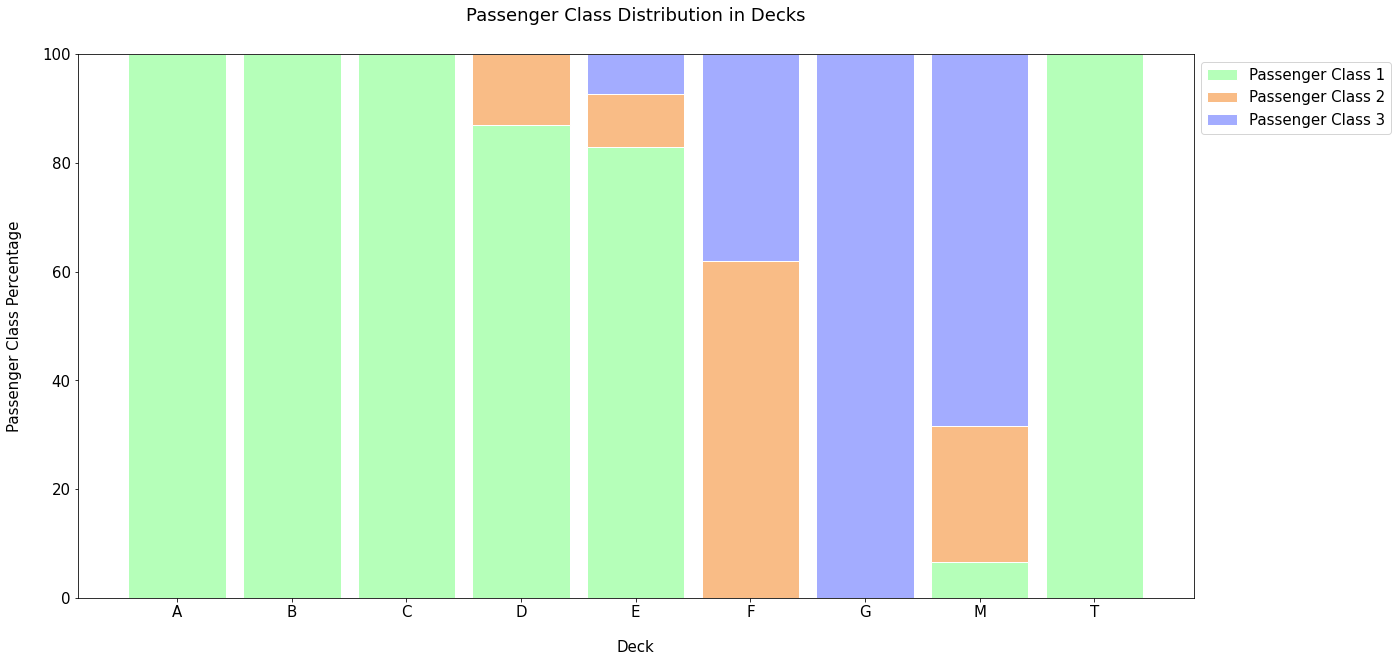

In [19]:
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0] # Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T'], dtype='object', name='Deck')
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [20]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'


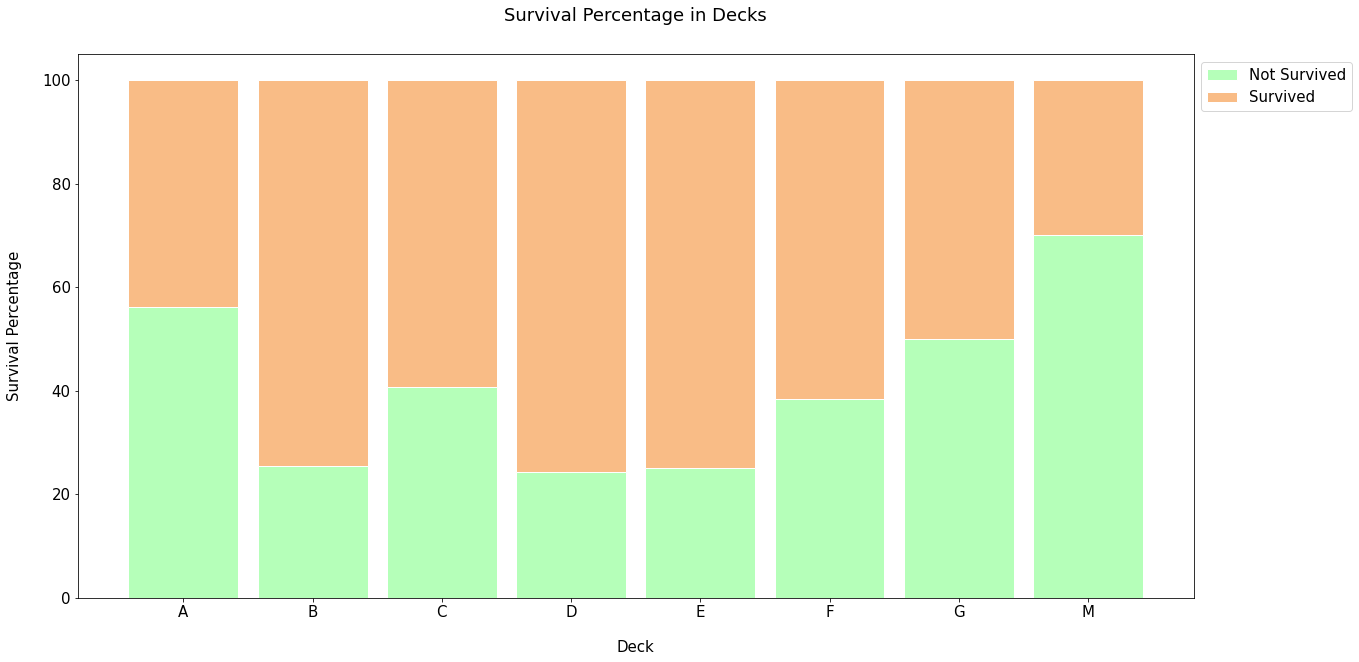

In [21]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [22]:
df_all['Deck'].head()

0    M
1    C
2    M
3    C
4    M
Name: Deck, dtype: object

In [23]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [24]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




#### 1.3 Target Distribution

* 38.38% (342/891) of training set is Class 1
* 61.62% (549/891) of training set is Class 0

In [28]:
df_train['Survived'].value_counts() 

0.0    549
1.0    342
Name: Survived, dtype: int64

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


Text(0.5, 1.05, 'Training Set Survival Distribution')

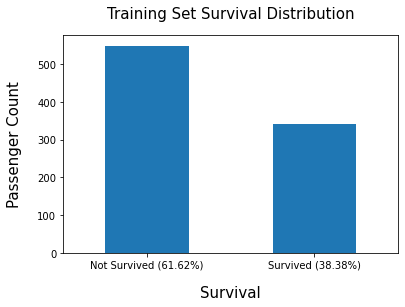

In [54]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print(f'{survived} of {df_train.shape[0]} passengers survived and it is the {survived_per:.2f}% of the training set.')
print(f'{not_survived} of {df_train.shape[0]} passengers didnt survive and it is the {not_survived_per:.2f}% of the training set.')

df_train['Survived'].value_counts().plot(kind='bar')
plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), [f'Not Survived ({not_survived_per:.2f}%)', f'Survived ({survived_per:.2f}%)'], rotation=0)
plt.title('Training Set Survival Distribution', size=15, y=1.05)


#### 1.4 Correlations